## The Effects of Spin Rate on a MLB Pitcher's Performance: A Case Study on the 2015 - 2023 Seasons

For my junior year AP Research class, I chose to do my research project on the correlation that a ball's spin rate has on a variety of different analytics for pitchers for the 2022 MLB season. While I was really proud the work I did on that project, I was also motivated to expand on what I had learned.

I had originally relied on manually importing [StatCast](https://www.mlb.com/glossary/statcast) stats from [Baseball Savant](https://baseballsavant.mlb.com), manipulating data in Excel, and using [StatCrunch](https://www.statcrunch.com) to report my findings.  After completing an online course by the University of Michigan titled ["Foundations of Sports Analytics: Data, Representation, and Models in Sports"](https://online.umich.edu/courses/foundations-sports-analytics/) I realized there was a 'better' way.

Using many of the coding principals from that course along with [pybaseball](https://github.com/jldbc/pybaseball), a Python package for baseball data analysis, I was able to streamline my analysis as well as make it much easiser to expand the analysis across multiple seasons.

### SetUp
The first thing we need to do is to import packages which allow us to collect,analyze, and visualize data. I've learned that these packages are pretty standard within the data analytics community.

In [3]:
# normal imports
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# disable warnings
warnings.filterwarnings('ignore')

As I mentioned above, pybaseball is a really useful Python package.  It allows you to import stats into a dataframe directly from popular sites, including Baseball Savant (which has the StatCast stats that I wanted to use for my analysis).  Unfortunately, pybaseball didn't have a built-in function that grabbed all of the columns of data that I had previously used when importing things manually.  However, by looking at how the existing pybaseball functions were defined, I was able to create a custom function that did exactly what I needed:

```python
def statcast_pitcher_pitch_spin(year: int, minP: int = 100) -> pd.DataFrame:
    url = f"https://baseballsavant.mlb.com/leaderboard/custom?year={year}&type=pitcher&filter=&sort=4&sortDir=asc&min={minP}&selections=k_percent,bb_percent,p_era,batting_avg,exit_velocity_avg,whiff_percent,groundballs_percent,flyballs_percent,popups_percent,fastball_avg_spin,breaking_avg_spin,n_breaking_formatted,offspeed_avg_spin,n_offspeed_formatted&csv=true"
    res = requests.get(url, timeout=None).content
    data = pd.read_csv(io.StringIO(res.decode('utf-8')))
    data = sanitize_statcast_columns(data)
    return data
```

After doing that, we can import this new function and use it to create a dataframe with the stats that we want.  The years are set from 2015 (the start of the StatCast Era) to 2023 (the current year as of publishing this), and the minimum amount of plate appearances against the pitcher is set to 100. The results of my custom function are listed on the columns below.

In [4]:
# pybaseball
from pybaseball import statcast_pitcher_pitch_spin

data_spin_all = statcast_pitcher_pitch_spin('2023,2022,2021,2020,2019,2018,2017,2016,2015', minP=100)
print(data_spin_all.columns.tolist())
data_spin_all

['last_name', 'first_name', 'player_id', 'year', 'k_percent', 'bb_percent', 'p_era', 'batting_avg', 'exit_velocity_avg', 'whiff_percent', 'groundballs_percent', 'flyballs_percent', 'popups_percent', 'fastball_avg_spin', 'breaking_avg_spin', 'n_breaking_formatted', 'offspeed_avg_spin', 'n_offspeed_formatted']


,last_name,first_name,player_id,year,k_percent,bb_percent,p_era,batting_avg,exit_velocity_avg,whiff_percent,groundballs_percent,flyballs_percent,popups_percent,fastball_avg_spin,breaking_avg_spin,n_breaking_formatted,offspeed_avg_spin,n_offspeed_formatted
0,Colon,Bartolo,112526,2015,16.7,2.9,4.16,0.281,88.9,14.4,44.1,23.2,5.7,2161,2164.0,10.0,1727.0,7.4
1,Hawkins,LaTroy,115629,2015,21.0,4.3,3.26,0.286,89.7,17.0,55.4,18.2,5.8,2051,2072.0,16.6,1698.0,8.0
2,Wolf,Randy,150116,2015,17.4,9.3,6.23,0.319,89.0,16.2,46.2,17.9,5.1,2032,2176.0,40.2,1669.0,11.1
3,Marquis,Jason,150302,2015,17.1,6.5,6.46,0.330,90.4,21.3,48.8,17.1,3.7,1782,1977.0,19.4,1239.0,21.2
4,Burnett,A.J.,150359,2015,20.5,7.0,3.18,0.275,89.8,21.1,55.0,14.1,4.0,2009,2023.0,29.4,1678.0,8.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4309,Woo,Bryan,693433,2023,25.9,7.3,4.75,0.242,87.2,27.8,38.8,28.9,7.9,2179,2358.0,11.8,1713.0,3.6
4310,Elder,Bryce,693821,2023,17.6,7.9,3.46,0.238,89.5,23.7,53.0,20.6,4.8,1998,2398.0,36.7,2032.0,12.1
4311,Pfaadt,Brandon,694297,2023,20.5,6.6,6.91,0.303,90.4,24.6,34.1,30.1,8.5,2445,2668.0,32.9,1946.0,14.7
4312,Shuster,Jared,694363,2023,13.0,11.4,5.00,0.250,89.8,21.3,35.2,29.0,12.4,2136,2204.0,34.2,1492.0,21.7


A huge part of this entire study is that I want to isolate both the fastball's average spin rate and also the secondary pitch's spin rate. However, there are three types of pitches listed on StatCast: fastballs, breaking balls, and offspeed. To simplify things, I wanted to group both breaking balls and offspeed together. When originally looking at them separately, I noticed a high amount of outliers where some pitchers threw a pitch labeled as "offspeed" with a lot more spin than typically seen by anyone else's pitches of that type. Because of this, I used a weighted average formula (breaking % * breaking spin + offspeed % * offspeed spin) to determine the exact average spin rate of a secondary pitch thrown by a pitcher, now labeled as `pitch2_avg_spin`.

In [5]:
# massage data - change NaN values to zero, formula to calculate secondary pitch average spin based on pitch usage percentages
data_spin_all = data_spin_all.fillna(0)
data_spin_all["pitch2_avg_spin"] = (data_spin_all['n_breaking_formatted'] / (data_spin_all['n_breaking_formatted'] + data_spin_all['n_offspeed_formatted']) * data_spin_all['breaking_avg_spin']) + \
                                   (data_spin_all['n_offspeed_formatted'] / (data_spin_all['n_breaking_formatted'] + data_spin_all['n_offspeed_formatted']) * data_spin_all['offspeed_avg_spin'])

# change NaN to zero again (formula output to handle pitchers with no secondary pitches)
data_spin_all = data_spin_all.fillna(0)
data_spin_all["pitch2_avg_spin"] = data_spin_all["pitch2_avg_spin"].astype('int')
data_spin_all = data_spin_all.drop(columns=['player_id','breaking_avg_spin','offspeed_avg_spin','n_breaking_formatted','n_offspeed_formatted'])
data_spin_all

,last_name,first_name,year,k_percent,bb_percent,p_era,batting_avg,exit_velocity_avg,whiff_percent,groundballs_percent,flyballs_percent,popups_percent,fastball_avg_spin,pitch2_avg_spin
0,Colon,Bartolo,2015,16.7,2.9,4.16,0.281,88.9,14.4,44.1,23.2,5.7,2161,1978
1,Hawkins,LaTroy,2015,21.0,4.3,3.26,0.286,89.7,17.0,55.4,18.2,5.8,2051,1950
2,Wolf,Randy,2015,17.4,9.3,6.23,0.319,89.0,16.2,46.2,17.9,5.1,2032,2066
3,Marquis,Jason,2015,17.1,6.5,6.46,0.330,90.4,21.3,48.8,17.1,3.7,1782,1591
4,Burnett,A.J.,2015,20.5,7.0,3.18,0.275,89.8,21.1,55.0,14.1,4.0,2009,1943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4309,Woo,Bryan,2023,25.9,7.3,4.75,0.242,87.2,27.8,38.8,28.9,7.9,2179,2207
4310,Elder,Bryce,2023,17.6,7.9,3.46,0.238,89.5,23.7,53.0,20.6,4.8,1998,2307
4311,Pfaadt,Brandon,2023,20.5,6.6,6.91,0.303,90.4,24.6,34.1,30.1,8.5,2445,2445
4312,Shuster,Jared,2023,13.0,11.4,5.00,0.250,89.8,21.3,35.2,29.0,12.4,2136,1927


### Linear Regression
After attaining the formula, I then needed to run a linear regression test on the entire data-sheet to view the correlation between both Fastball Spin and Pitch 2 Spin and all of the other variables listed above (K%, BB%, etc.). When running a linear regression test, a lot of information is given, but in this case, the only thing that is needed to determine the correlation is the p-value. Therefore, I coded this section so that the output below would only show the necessary p-values, and no other non-essential information would be included. When the p-value is below 0.05, it means that there is a correlation between the two variables. As shown below, there are a vast number of these statistics that have p-values below 0.05, meaning that there **_is_** a correlation between a lot of these statistics and the average spin of both fastballs and secondary pitches.  

In [6]:
# calculate p-value per year

from scipy.stats import pearsonr

# method to use for 'corr' function to return p-value
# https://stackoverflow.com/questions/52741236/how-to-calculate-p-values-for-pairwise-correlation-of-columns-in-pandas
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

# change settings for prettier output of p-value correlations
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# list of years to cycle through for finding specific year p-values
years = [2023,2022,2021,2020,2019,2018,2017,2016,2015]

# all years
with pd.option_context('display.float_format', '{:0.6f}'.format):
    data_spin_pv = data_spin_all.drop(columns=['last_name', 'first_name', 'year'])
    corr = data_spin_pv.corr(method=pearsonr_pval,numeric_only=True)
    print("All Years\n{}\n".format(corr.loc[['fastball_avg_spin','pitch2_avg_spin'], ~corr.columns.isin(['fastball_avg_spin','pitch2_avg_spin'])]))

# individual years
for y in years:
    with pd.option_context('display.float_format', '{:0.6f}'.format):
        data_spin_year = data_spin_all.loc[data_spin_all['year'] == y]
        data_spin_pv = data_spin_year.drop(columns=['last_name', 'first_name', 'year'])
        corr = data_spin_pv.corr(method=pearsonr_pval,numeric_only=True)
        corr2 = corr.loc[['fastball_avg_spin','pitch2_avg_spin'], ~corr.columns.isin(['fastball_avg_spin','pitch2_avg_spin'])]
        print("\n{}: P-Values\n{}\n".format(y,corr.loc[['fastball_avg_spin','pitch2_avg_spin'], ~corr.columns.isin(['fastball_avg_spin','pitch2_avg_spin'])]))
        # just print the statistically significant correlations (< 0.05)
        corr2 = corr2[corr2 < .05].unstack().transpose()\
            .sort_values( ascending=True).dropna()
        print(corr2)
        # try out printing a p-value heatmap to visualize correlations; decided not to use this :) 
        # plt.figure(figsize=(6,4))
        # sns.set(font_scale=.8)
        # sns.heatmap(corr.loc[['fastball_avg_spin','pitch2_avg_spin'], ~corr.columns.isin(['fastball_avg_spin','pitch2_avg_spin'])].transpose(),annot=True, cmap="YlGnBu",annot_kws={"size": 8},fmt='.4f')
        # plt.title('P-Value Heatmap - {}'.format(y))

All Years
                   k_percent  bb_percent    p_era  batting_avg  exit_velocity_avg  whiff_percent  groundballs_percent  flyballs_percent  popups_percent
fastball_avg_spin   0.000000    0.000000 0.000000     0.000000           0.010150       0.000000             0.000000          0.000000        0.000000
pitch2_avg_spin     0.000000    0.000000 0.000000     0.000000           0.001091       0.000000             0.094672          0.000126        0.003592


2023: P-Values
                   k_percent  bb_percent    p_era  batting_avg  exit_velocity_avg  whiff_percent  groundballs_percent  flyballs_percent  popups_percent
fastball_avg_spin   0.000000    0.019519 0.006475     0.000000           0.023986       0.000000             0.000001          0.000002        0.000000
pitch2_avg_spin     0.012248    0.411112 0.114177     0.022656           0.028484       0.192534             0.944723          0.993843        0.309891

whiff_percent        fastball_avg_spin   0.000000
k_percent 

### Pretty Pictures
After obtaining the p-values, I then wanted to graph these relationships on scatterplots. I overlayed each year ontop of each other using the "hue" function, and then graphed each relationship using the pitch's spin as the x-value, and the differing statistics as the y-value. After that, I wanted to create individual, year-by-year graphs for the statistics I deem to be most important in there being a correlation. This is all layed out below. 

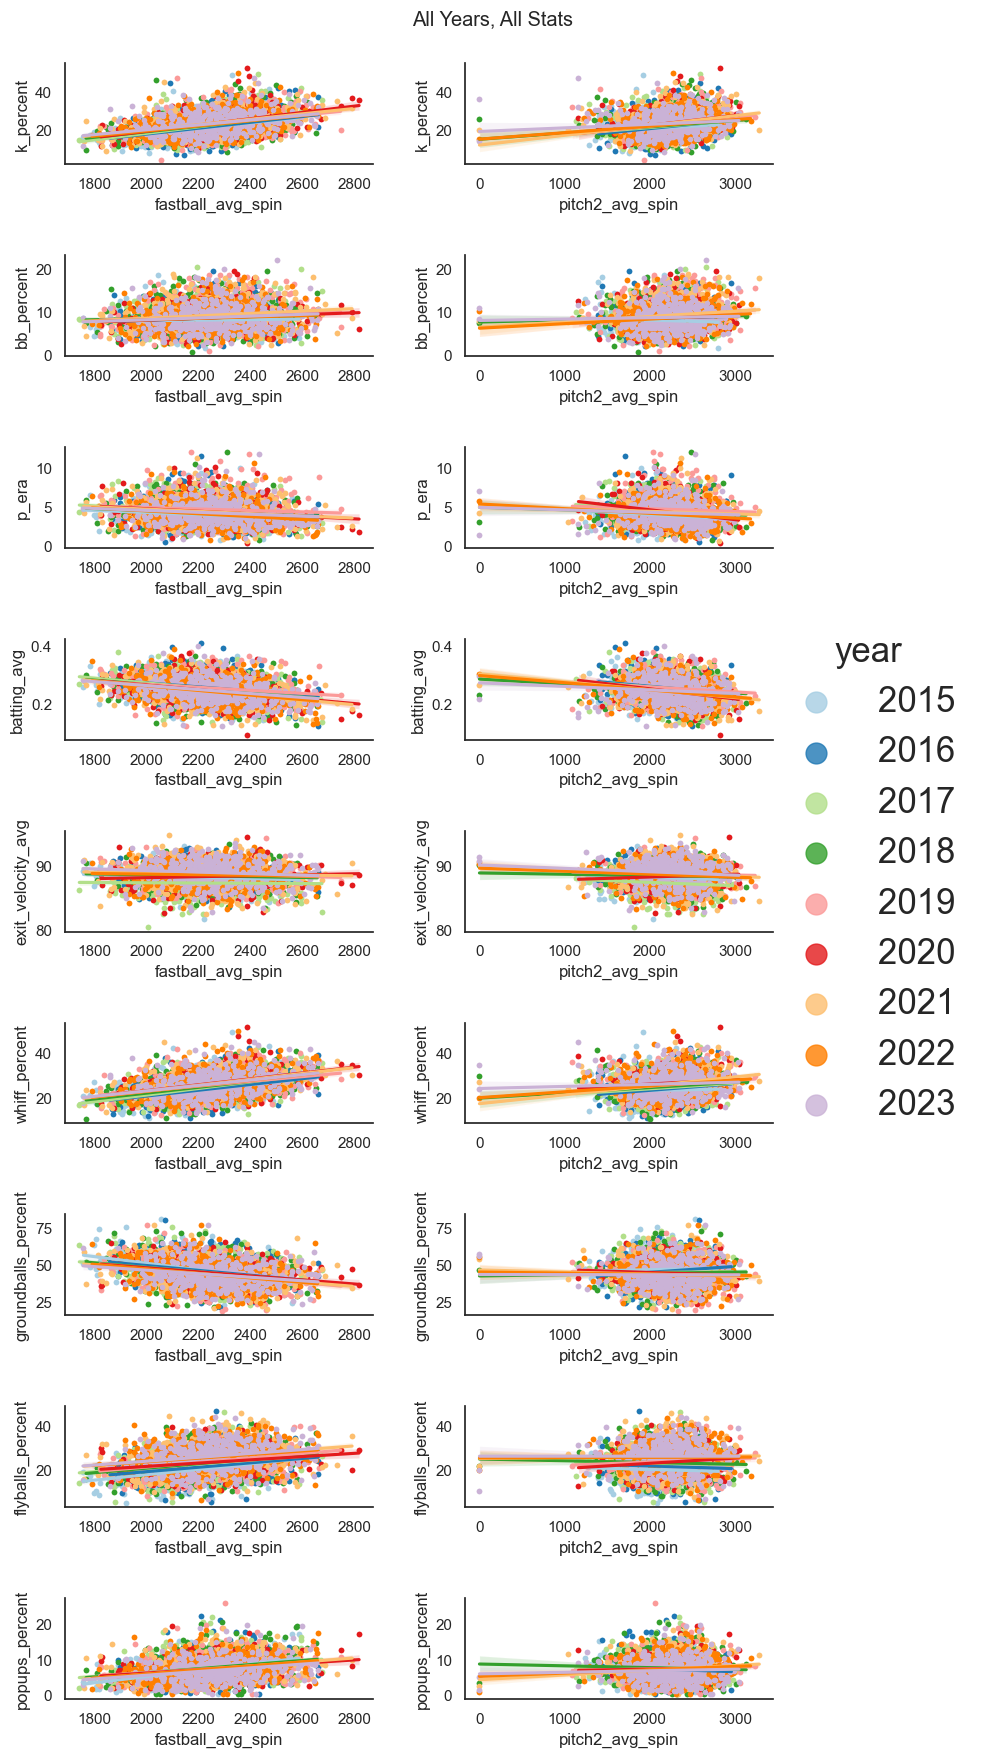

In [7]:
custom_palette=sns.color_palette("Paired",9)
sns.set_theme(style="white",palette=custom_palette)
plt.rc('legend',fontsize=25, title_fontsize=25,markerscale=5.0)
pp = sns.pairplot(data=data_spin_all,y_vars=["k_percent", "bb_percent", "p_era", "batting_avg","exit_velocity_avg", "whiff_percent", "groundballs_percent", "flyballs_percent", "popups_percent"],\
                  x_vars=["fastball_avg_spin", "pitch2_avg_spin"], kind='reg',markers='.',hue='year',height=2, aspect=2)
pp = pp.map(plt.scatter)
xlabels,ylabels = [],[]

#handles = pp._legend_data.values()
#labels = pp._legend_data.keys()
#pp.fig.legend(handles=handles, labels=labels)


for ax in pp.axes[-1,:]:
    xlabel = ax.xaxis.get_label_text()
    xlabels.append(xlabel)
for ax in pp.axes[:,0]:
    ylabel = ax.yaxis.get_label_text()
    ylabels.append(ylabel)

for i in range(len(xlabels)):
    for j in range(len(ylabels)):
        pp.axes[j,i].xaxis.set_label_text(xlabels[i],visible=True)
        pp.axes[j,i].yaxis.set_label_text(ylabels[j],visible=True)

for ax in pp.axes.flat:
    ax.tick_params(axis='both', labelleft=True, labelbottom=True)

pp.fig.subplots_adjust(top=.95)
pp.fig.suptitle("All Years, All Stats")
plt.subplots_adjust(wspace=0.3, hspace=0.9)
plt.show()

Text(0.5, 0.98, 'Fastball Spin & K%')

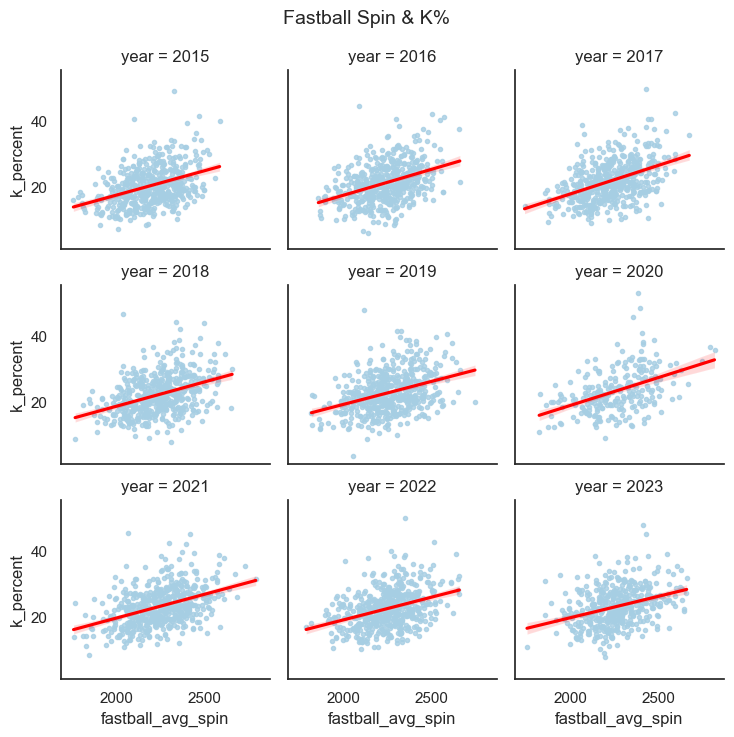

In [8]:
# drill down into a relationship across multiple years; this one is 'fastball_avg_spin' & k_percent'
lm=sns.lmplot(x='fastball_avg_spin', y='k_percent', data=data_spin_all, col='year',col_wrap=3,height=2.5,line_kws={'color':'red'},markers='.')

# Add a title
fig = lm.fig 
fig.subplots_adjust(top=.9)
fig.suptitle("Fastball Spin & K%", fontsize=14)

Text(0.5, 0.98, 'Pitch-2 Spin & K%')

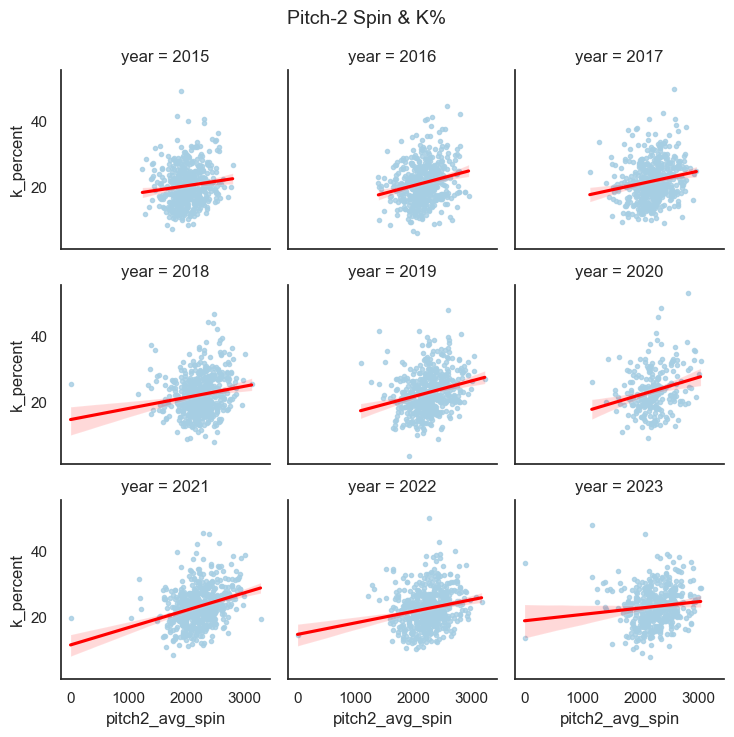

In [9]:
# 'pitch2_avg_spin' & 'k_percent'
lm = sns.lmplot(x='pitch2_avg_spin', y='k_percent', data=data_spin_all, col='year',col_wrap=3,height=2.5,line_kws={'color':'red'},markers='.')

# Add a title
fig = lm.fig 
fig.subplots_adjust(top=.9)
fig.suptitle("Pitch-2 Spin & K%", fontsize=14)

Text(0.5, 0.98, 'Fastball Spin & ERA')

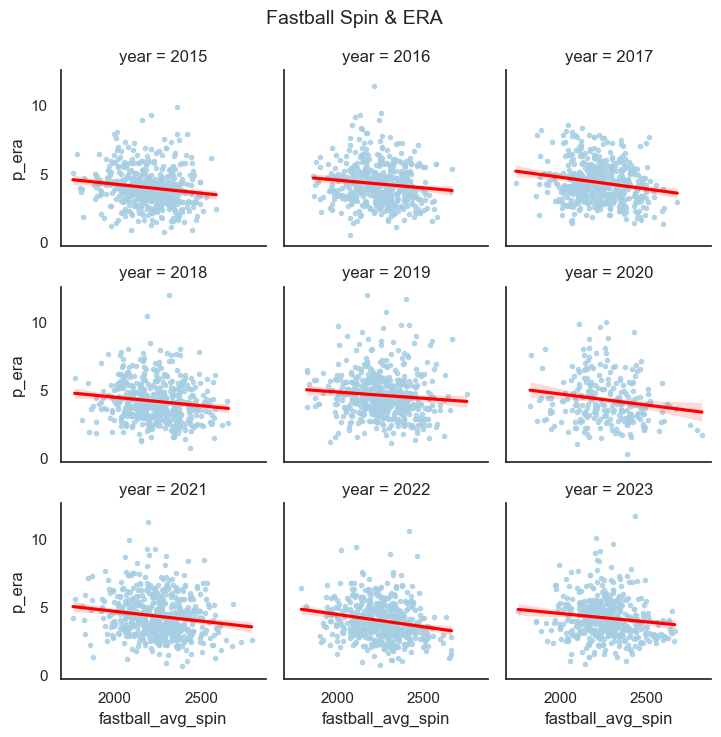

In [10]:
# 'fastball_avg_spin' & 'p_era'
lm = sns.lmplot(x='fastball_avg_spin', y='p_era', data=data_spin_all, col='year',col_wrap=3,height=2.5,line_kws={'color':'red'},markers='.')

# Add a title
fig = lm.fig 
fig.subplots_adjust(top=.9)
fig.suptitle("Fastball Spin & ERA", fontsize=14)

Text(0.5, 0.98, 'Pitch-2 Spin & ERA')

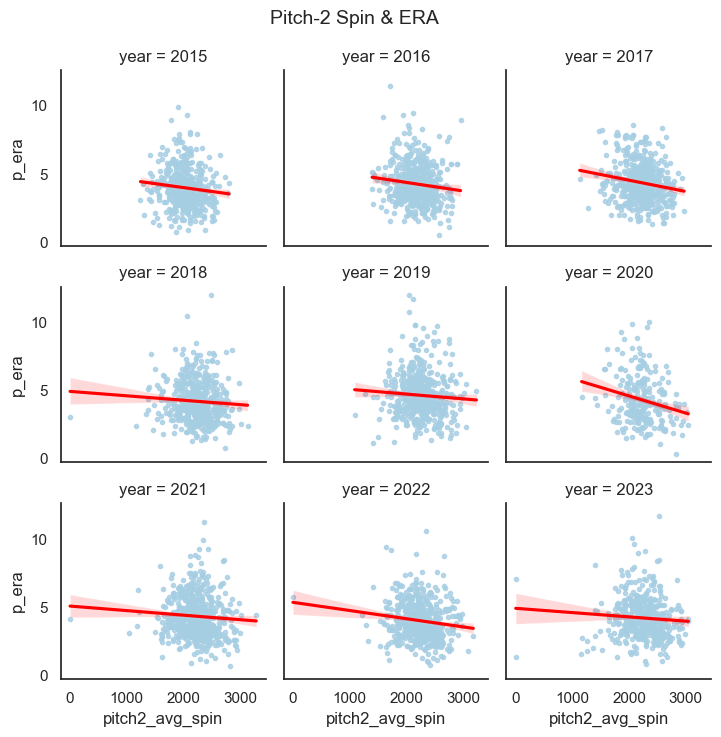

In [11]:
# 'pitch2_avg_spin' & 'p_era'
lm = sns.lmplot(x='pitch2_avg_spin', y='p_era', data=data_spin_all, col='year',col_wrap=3,height=2.5,line_kws={'color':'red'},markers='.')

# Add a title
fig = lm.fig 
fig.subplots_adjust(top=.9)
fig.suptitle("Pitch-2 Spin & ERA", fontsize=14)

Text(0.5, 0.98, 'Fastball Spin & Batting Average Against')

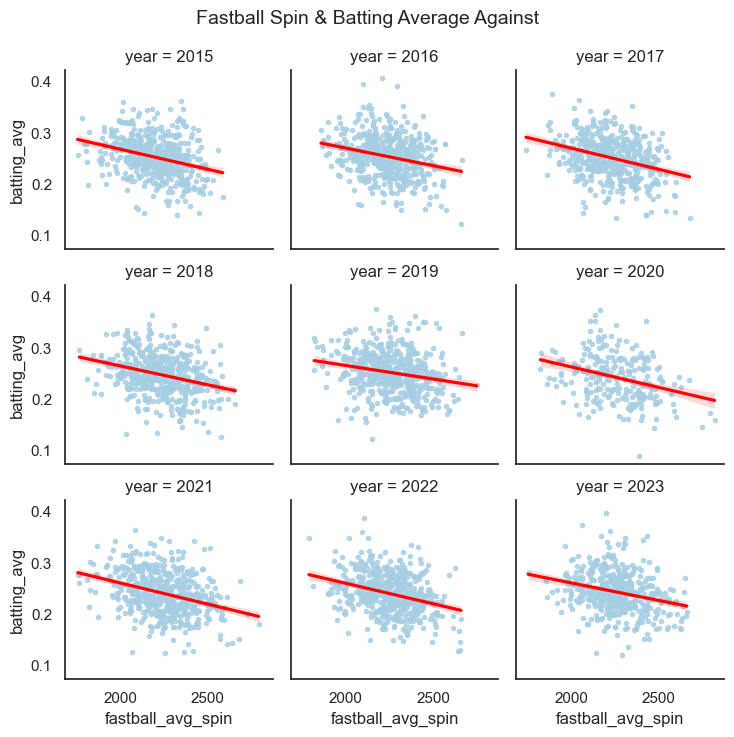

In [12]:
# 'fastball_avg_spin' & 'batting_avg'
lm = sns.lmplot(x='fastball_avg_spin', y='batting_avg', data=data_spin_all, col='year',col_wrap=3,height=2.5,line_kws={'color':'red'},markers='.')

# Add a title
fig = lm.fig 
fig.subplots_adjust(top=.9)
fig.suptitle("Fastball Spin & Batting Average Against", fontsize=14)

Text(0.5, 0.98, 'Pitch-2 Spin & Batting Average Against')

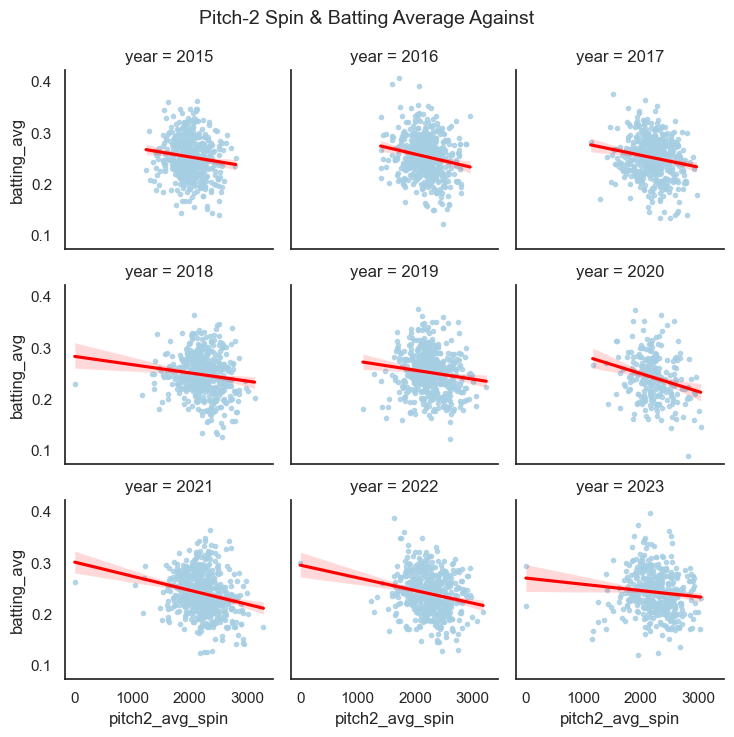

In [13]:
# 'pitch2_avg_spin' & 'batting_avg'
lm = sns.lmplot(x='pitch2_avg_spin', y='batting_avg', data=data_spin_all, col='year',col_wrap=3,height=2.5,line_kws={'color':'red'},markers='.')

# Add a title
fig = lm.fig 
fig.subplots_adjust(top=.9)
fig.suptitle("Pitch-2 Spin & Batting Average Against", fontsize=14)

Text(0.5, 0.98, 'Fastball Spin & Whiff %')

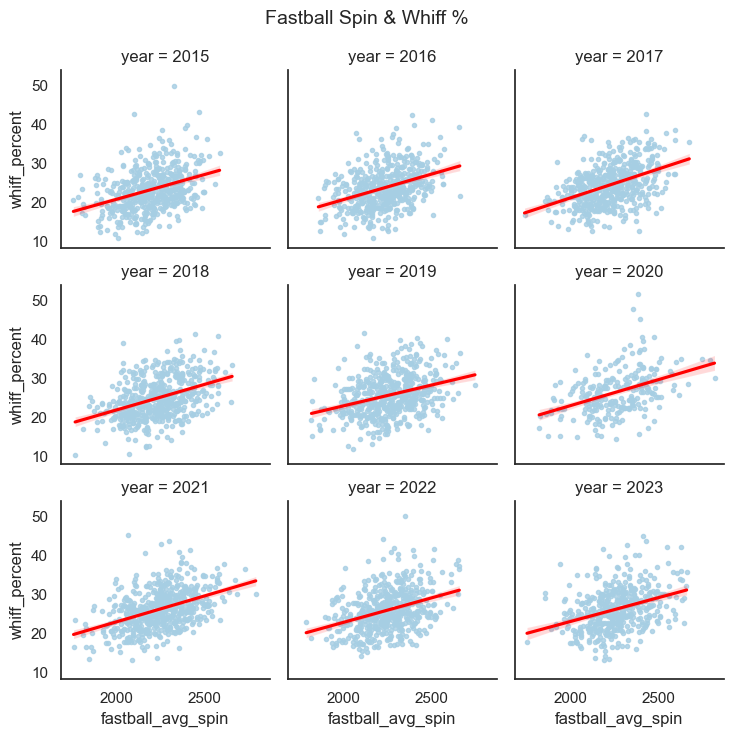

In [14]:
# 'fastball_avg_spin' & 'whiff_percent'
lm = sns.lmplot(x='fastball_avg_spin', y='whiff_percent', data=data_spin_all, col='year',col_wrap=3,height=2.5,line_kws={'color':'red'},markers='.')

# Add a title
fig = lm.fig 
fig.subplots_adjust(top=.9)
fig.suptitle("Fastball Spin & Whiff %", fontsize=14)

Text(0.5, 0.98, 'Pitch-2 Spin & Whiff %')

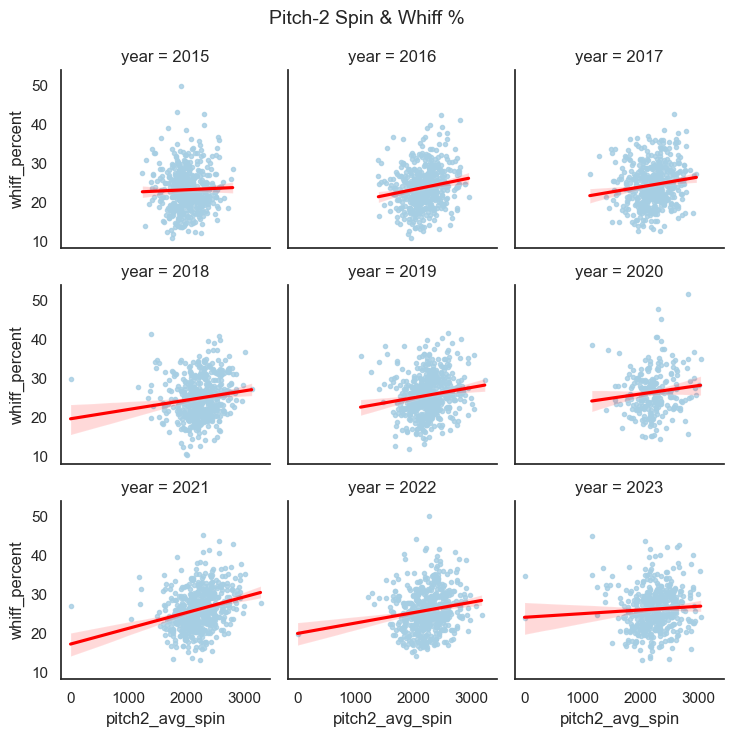

In [15]:
# 'pitch2_avg_spin' & 'whiff_percent'
lm = sns.lmplot(x='pitch2_avg_spin', y='whiff_percent', data=data_spin_all, col='year',col_wrap=3,height=2.5,line_kws={'color':'red'},markers='.')

# Add a title
fig = lm.fig 
fig.subplots_adjust(top=.9)
fig.suptitle("Pitch-2 Spin & Whiff %", fontsize=14)

### Conclusion
In conclusion, based on the p-values and subsequent graphs throughout the years 2015-2023, there is a correlation between the change in both pitch type's spin and the change in opponent batting average, K%, BB%, ERA, Whiff Rate, flyball rate, and popup rate. With groundball rate, there is only a correlation with the fastball's average spin, and not Pitch 2. There is a gap here, however - the data that's available isn't as granular as I would like. Not much data exists for correlating spin rate and pitch-by-pitch analysis. The data shown here isn't linked to the pitch type, but instead linked to the pitcher. Moreover, the concept of spin rate is very new and will continue to develop and deepen over time, which will certainly help improve these findings. While there are limitations here, the correlation still is valid and shows that there is a connection between the change in spin rate and the performance of a pitcher. 